<a href="https://colab.research.google.com/github/Bryan-Az/ClusteringMethod-Slate/blob/main/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

# Data Loading & Pre-processing & Selection

In [2]:
# reading in the metadata for the audio files (will be using the numerical data)
actors_meta_df = pd.read_csv('data_samples/actors_meta_df.csv')

In [3]:
#selecting the numerical categorical label-like emotion data
numerical_emotion_df = actors_meta_df[['modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition']]
# d-typing the columns to be floats
numerical_emotion_df = numerical_emotion_df.astype(float)

In [4]:
numerical_emotion_df.head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition
0,3.0,1.0,1.0,1.0,2.0,2.0
1,3.0,1.0,2.0,1.0,2.0,1.0
2,3.0,1.0,2.0,2.0,1.0,1.0
3,3.0,1.0,3.0,1.0,1.0,2.0
4,3.0,1.0,3.0,2.0,2.0,2.0


In [5]:
# preprocessing using the min-max scaler to make the columns all comparable
scaler = MinMaxScaler()
scaler.fit(numerical_emotion_df)
scaled_numerical_emotion_df = pd.DataFrame(scaler.transform(numerical_emotion_df))

In [6]:
scaled_numerical_emotion_df.describe() # the transformed data is now in a range of 0-1

,0,1,2,3,4,5
count,1440.0,1440.0,1440.000000,1440.000000,1440.000000,1440.000000
mean,0.0,0.0,0.533333,0.466667,0.500000,0.500000
std,0.0,0.0,0.310765,0.499061,0.500174,0.500174
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.285714,0.000000,0.000000,0.000000
50%,0.0,0.0,0.571429,0.000000,0.500000,0.500000
75%,0.0,0.0,0.857143,1.000000,1.000000,1.000000
max,0.0,0.0,1.000000,1.000000,1.000000,1.000000


# Exploratory Visualization
Goal is to see if there are any obvious clusters that would be identified by K-Means

In [7]:
numerical_emotion_df.shape # 1440 rows, 6 columns (plotting in terms of unique combinations of the 6 cols)

(1440, 6)

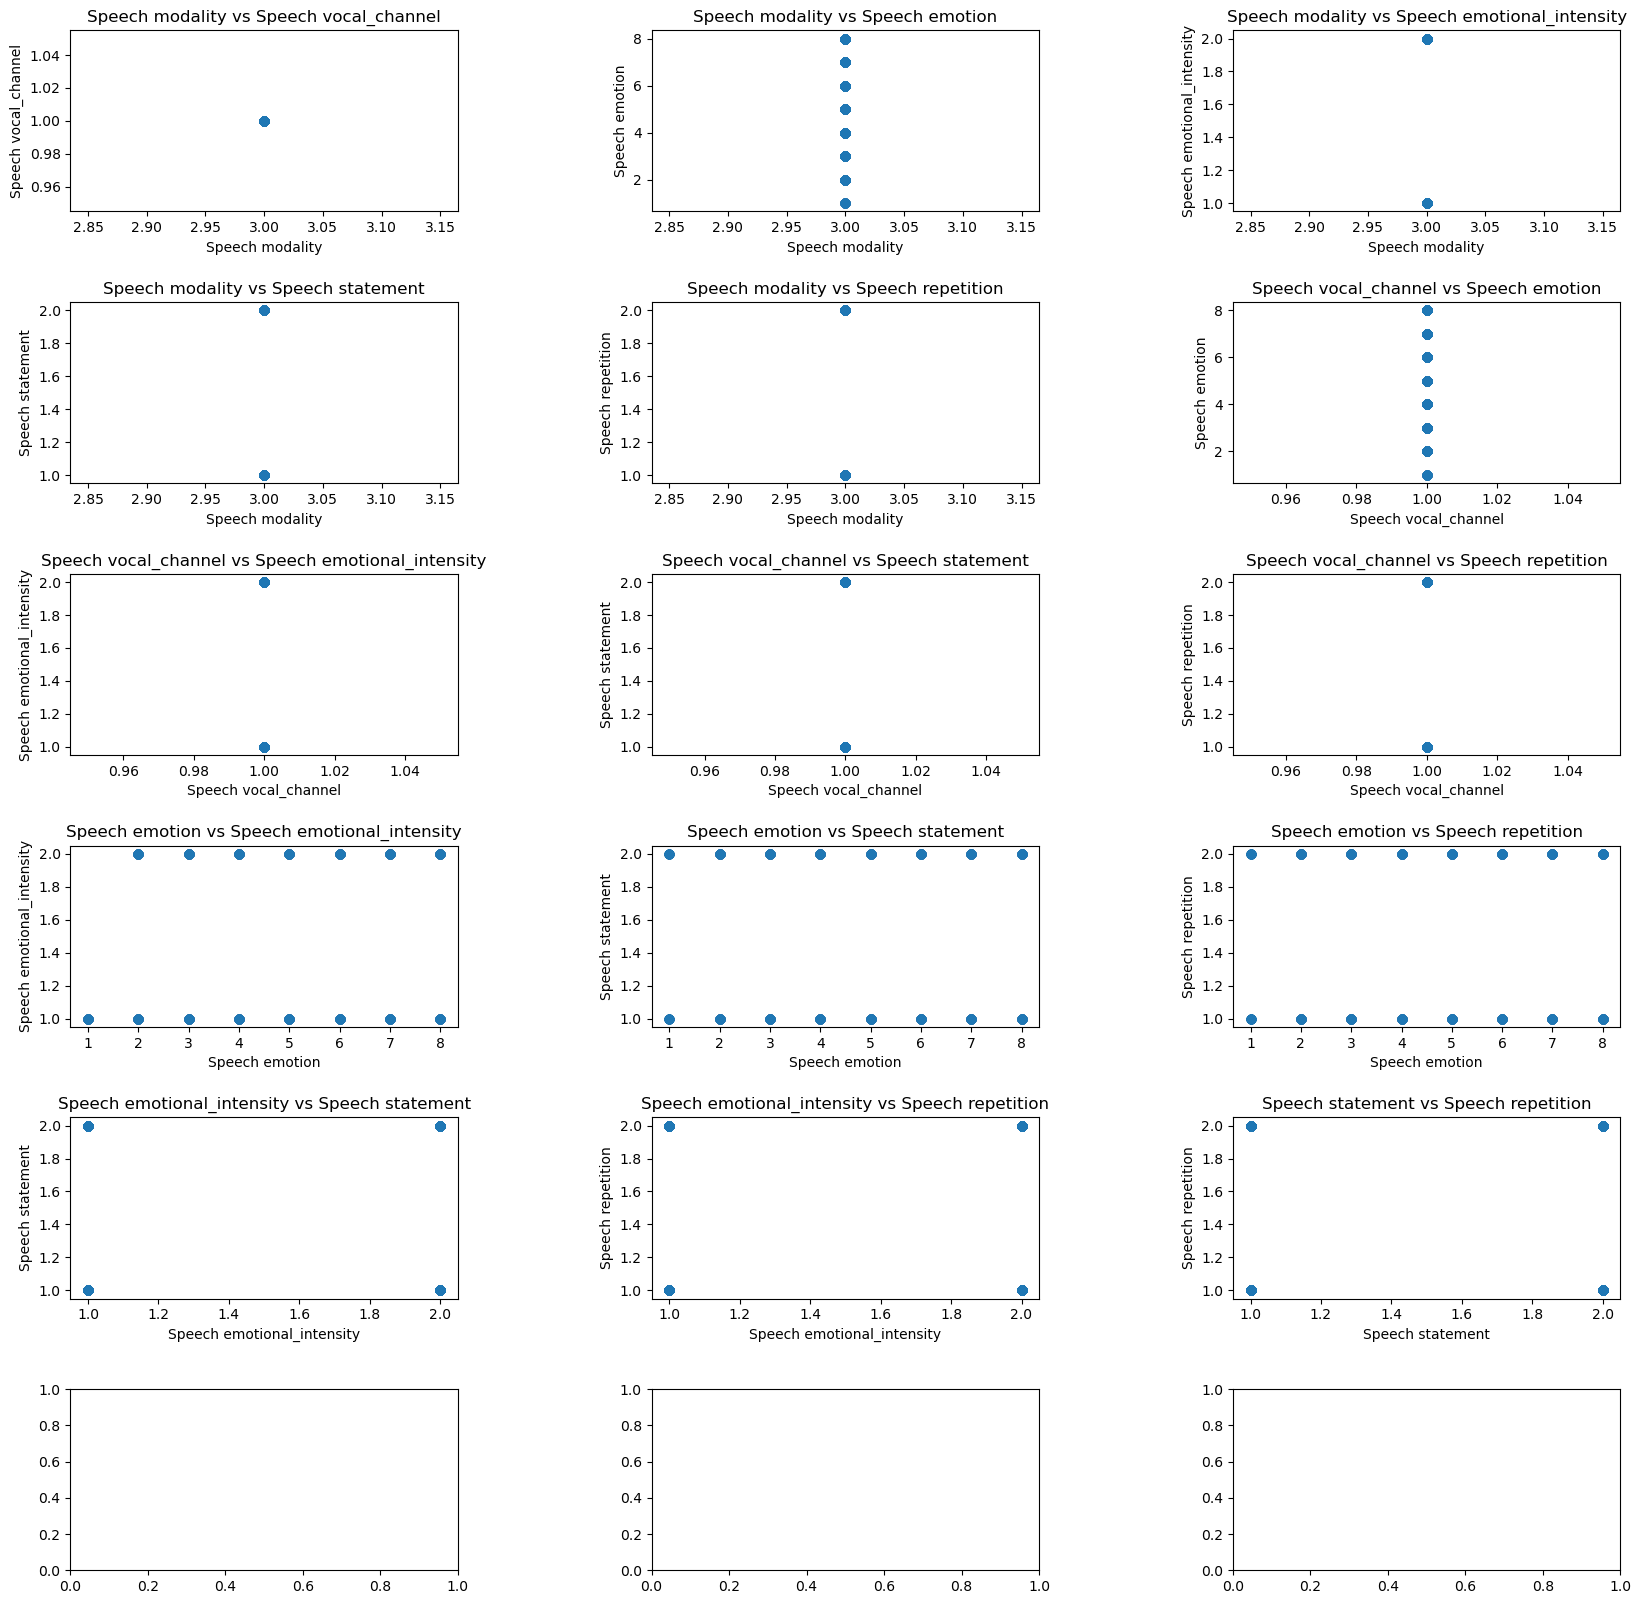

In [8]:
import itertools
import itertools
# plot a scatter plot of the data to see if there are any obvious clusters (as is multi-dimensional, we will plot in a sequence of 2D plots)
# plotting a grid with matplotlib (plotting in terms of unique combinations of the 6 cols)
columns = numerical_emotion_df.columns
# we want to make sure we don't plot a column against itself, so we will use itertools to get all the unique combinations of the columns
# Get unique combinations of columns
combinations = list(itertools.combinations(columns, 2))

# Plot a scatter plot of the data to see if there are any obvious clusters
fig, axs = plt.subplots(6, 3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axs = axs.ravel()

for i, (col1, col2) in enumerate(combinations):
    axs[i].scatter(numerical_emotion_df.loc[:, col1], numerical_emotion_df.loc[:, col2])
    axs[i].set_title('Speech ' + col1 + ' vs Speech ' + col2)
    axs[i].set_xlabel('Speech ' + col1)
    axs[i].set_ylabel('Speech ' + col2)


## Insights from the scatter plots
There is 15 unique combinations using the 6 columns. 

The plots with the least number of EASILY seperable clusters (single cluster) is (in my opinion):
1. Speech 'modality' vs 'vocal_channel' (completely overlapping). 
2. Speech 'emotion' vs 'modality'
3. Speech 'emotion' vs 'vocal_channel'

Highly visibly seperable clusters are (in my opinion, in clusters of 4):
1. Speech 'statement' vs 'repetition' 
2. Speech 'emotional_intensity' vs 'repetition'
3. Speech 'emotional_intensity' vs 'statement'

Then the remaining are seperable in clusters of 2.

# Clustering using K-Means
I will only use the columns that are present in the highly seperable group to see if my predictions are accurate. I'd love to see more clusters overall, so I chose the columns with the most visible clusters. Furthermore, I will use the scaled numerical data instead of the original dataframe as clustering with k-means benefits from numeric and scaled data.

In [9]:
visibly_clustered_cols = ['emotional_intensity', 'statement', 'repetition']
# get the index of the visibly_clustered_cols from the columns list of the numerical_emotion_df
visibly_clustered_cols_index = [columns.get_loc(col) for col in visibly_clustered_cols]

In [10]:
print(columns)
print(visibly_clustered_cols_index)
clustered_df = scaled_numerical_emotion_df.iloc[:, visibly_clustered_cols_index]
clustered_df.head()

Index(['modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition'],
      dtype='object')
[3, 4, 5]


,3,4,5
0,0.0,1.0,1.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,1.0,1.0


In [11]:
km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(clustered_df)
y_predicted

array([0, 0, 3, ..., 3, 1, 2], dtype=int32)

In [12]:
clustered_df['cluster'] = y_predicted
# now lets rename the columns to the original names
clustered_df.columns = visibly_clustered_cols + ['cluster']
clustered_df.head()

/var/folders/b8/b_prs9t152qc96jlgz5zhwt00000gn/T/ipykernel_64446/2112228804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_df['cluster'] = y_predicted


,emotional_intensity,statement,repetition,cluster
0,0.0,1.0,1.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,3
3,0.0,0.0,1.0,1
4,1.0,1.0,1.0,2


In [13]:
cluster_combinations = list(itertools.combinations(visibly_clustered_cols, 2))
cluster_combinations

[('emotional_intensity', 'statement'),
 ('emotional_intensity', 'repetition'),
 ('statement', 'repetition')]

In [14]:
clustered_df.cluster.unique()

array([0, 3, 1, 2], dtype=int32)

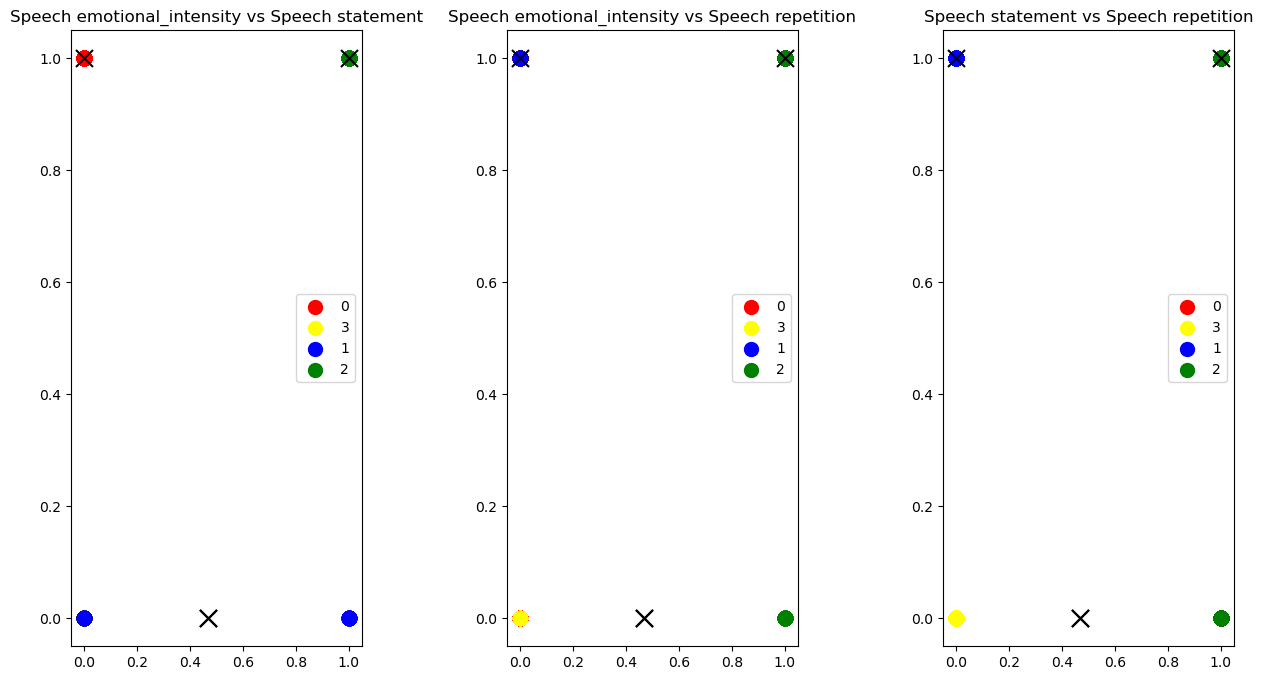

In [15]:
# now, we can plot the clusters to see how the data has been clustered
# we can further plot the centroids of the clusters to see where the clusters are centered

# Plot the clusters
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axs = axs.ravel()
cluster_combinations = list(itertools.combinations(visibly_clustered_cols, 2))
cluster_centroids = km.cluster_centers_
cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
for i, (col1, col2) in enumerate(cluster_combinations):
    # plot the legend using the color used in the scatter plot
    handles = []
    labels = []
    for g in clustered_df['cluster'].unique():
        ix = clustered_df['cluster'] == g
        scatter_x = clustered_df.loc[ix, col1]
        scatter_y = clustered_df.loc[ix, col2]
        color = cdict[g]
        handles.append(axs[i].scatter(scatter_x, scatter_y, c=color, label=g, s=100))
        labels.append(g)

    axs[i].legend(handles=handles, labels=labels)
    axs[i].set_title('Speech ' + col1 + ' vs Speech ' + col2)

    # plot all the centroids
    for centroid in cluster_centroids:
        axs[i].scatter(centroid[0], centroid[1], marker='x', s=150, c='black')





The final clusters of emotional intensity, speech repetition, and statement from the actor speech data are show above. (X show the centroids, where the mass of the dataset is present). I chose these columns because they have 4 visible clusters in each, making them easy to compare. We discovered this during the EDA visualization section.

Using the labels for each value category we can infer some meaning from the clusters. 

> Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

> Repetition (01 = 1st repetition, 02 = 2nd repetition).

> Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

## Insights 
1. Yellow is a large cluster that spans across all three unique combinations of these columns. It is also a strong emotional intensity group, similar to red. It is strictly on the first repetition of the statement. It is also strictly related to the statement "Dogs are sitting by the door".

2. Green is also present in all three of the plots. It features largely in the 'emotional_intensity' and 'repetition' plot in the middle. It has a first and second repetition. The centroid implies green is strictly a neutral intensity cluster. It is strictly on the statement "Kids are talking by the door".

3. Blue is present only in the 'emotional intensity vs 'statement' and 'statement' vs 'repetition' plots. (missing in emotional intensity - meaning it may be a neutral emotion cluster). Since it only has one cluster group in the 'statement' vs 'repetition' plot it implies it is scrictly related to the statement "Dogs are sitting by the door", on the second repetition. It is similar to yellow as it uses the same statement.

4. Red is present in all plots. It is strictly related to the statement "Kids are talking by the door" and it also has a second repetition. It also is highly a strong emotional intensity group. It is also similar to green as it uses the same statement.

## Assessing Groups Predictions
We want to verify if my assumptions of the insights of the clusters are somewhat correct. 
Since there are 4 groups, we must use a category as the y_true (inherent group in the data) with four groups or use a different group and reduce the categories. 
A category that quickly comes to mind is to use emotional intensity (2 groups) because it was one of the column features we used to cluster. 
The 4 categories would need to be reduced to an emotional intensity (01/normal or 02/strong) (given the insights of the cluster groups above).


1. Yellow (cluster 3) appears to show strong emotional intensity = 02/strong.
2. Green (cluster 2) appears to show normal emotional intensity = 01/normal.
3. Blue (cluster 1) appears to show normal emotional intensity = 01/normal.
4. Red (cluster 0) appears to show strong emotional intensity = 02/strong.

In [19]:
clustered_df.head()

,emotional_intensity,statement,repetition,cluster
0,0.0,1.0,1.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,3
3,0.0,0.0,1.0,1
4,1.0,1.0,1.0,2


In [25]:
def convert_cluster_to_intensity(cluster):
    ''' Converts clusters to predicted intensity levels
    '''
    if cluster == 0:
        return 2.0
    elif cluster == 1:
        return 1.0
    elif cluster == 2:
        return 1.0
    else:
        return 2.0

y_preds = clustered_df.cluster.apply(lambda x: convert_cluster_to_intensity(x))
y_true = numerical_emotion_df.emotional_intensity

In [26]:
confusion_matrix = contingency_matrix(y_true, y_preds)

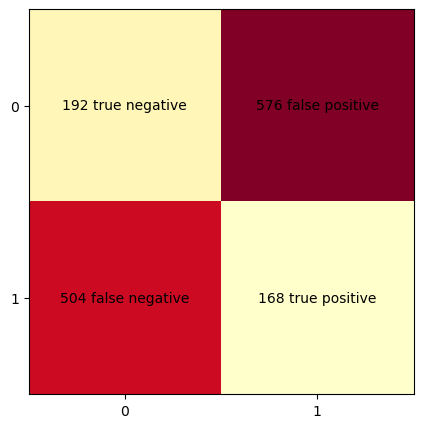

In [47]:
# Plot the confusion matrix with labels on the axes
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.YlOrRd)

# Add labels to the x-axis and y-axis
ax.set_xticks(np.arange(len(confusion_matrix)))
ax.set_yticks(np.arange(len(confusion_matrix)))

# show the values of the confusion matrix
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        matrix_label = ''
        if i == 0 and j == 0:
            matrix_label = 'true negative'
        elif i == 0 and j == 1:
            matrix_label = 'false positive'
        elif i == 1 and j == 0:
            matrix_label = 'false negative'
        elif i == 1 and j == 1:
            matrix_label = 'true positive'
        text = ax.text(j, i, str(confusion_matrix[i, j]) + ' ' + matrix_label, ha='center', va='center', color='black')
# Show the plot
plt.show()
 

In [48]:
accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / np.sum(confusion_matrix)
print('The accuracy is {accuracy} which means that {accuracy}% of the instances are classified correctly.'.format(accuracy=accuracy*100))

The accuracy is 25.0 which means that 25.0% of the instances are classified correctly.


In [28]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    c_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(c_matrix, axis=0)) / np.sum(c_matrix)

In [49]:
score = purity_score(y_true, y_preds)
print('The purity score is {score} which means that {score}% of the clusters are pure. {score}% of instances in the clusters are classified into their majority class (the incorrect class, in this case, as accuracy is 25%). It means that for most of the clusters, the largest number of members from a single class makes up {score}% of the clusters size on average.'.format(score=score*100))

The purity score is 75.0 which means that 75.0% of the clusters are pure. 75.0% of instances in the clusters are classified into their majority class (the incorrect class, in this case, as accuracy is 25%). It means that for most of the clusters, the largest number of members from a single class makes up 75.0% of the clusters size on average.


# Conclusion
Given I used a binary prediction using the single variable 'emotion_intensity' feature to reduce the clusters into y_preds, the accuracy of the clusters on the actual 'emotion_intensity' is only 25%. I think using the 'statement' feature might give slightly better accuracy as the centroids are closer to the 'statement' clusters which may imply the statement is a bigger determinor.